In [95]:
from PIL import Image, ImageDraw
import pandas as pd
import json
import os
import ast
from sklearn.model_selection import train_test_split
import wandb
from pytorch_lightning.loggers import WandbLogger
import torchvision
from transformers import DetrImageProcessor, DetrForObjectDetection
from torch.utils.data import DataLoader
import torch
import pytorch_lightning as pl
from pytorch_lightning import Trainer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#need a train / test/ val 
#Threshold accuracy for bb to be 0.95
#do 500x500 for images
#should we take 1000x1000 images and split them into 4 images? (shifting around the bounding boxes accordingly) 

#At inference, for a 1000x1000 image of id 'ABC', split into 4 iamges of 500x500 and have them be ABC_n , {n E 1-4 },then for the labelling 
#in the csv we will have to retransform where those bounding boxes actually should appear on the original 1000x1000 image and place metadata into csv submission



In [50]:
import os
print("Current Working Directory:", os.getcwd())



Current Working Directory: C:\Users\iansa\Zindi


In [29]:
COCO_DATASET = "dataset_coco_format.json"
DATA_FOLDER = 'Data'
TEST_CSV = "Test.csv"
IMAGE_FOLDER = "Images/Images"
TRAIN_CSV = "Train.csv"
labels_dict = {1: "Other", 2: "Tin", 3: "Thatch"}


In [30]:
# Load the data
TRAIN_CSV = "Data/Train.csv"
train_df = pd.read_csv(TRAIN_CSV)
train_df.columns

Index(['image_id', 'bbox', 'category_id', 'id'], dtype='object')

In [31]:
### Look at the image sizes for all
# Define the directory containing the images
directory_path = r'C:\Users\iansa\Zindi\Images\Images'

# List to hold the dimensions
image_dimensions = []

# Loop through all files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith(".tif"):  # Check for .tif files
        # Construct full file path
        file_path = os.path.join(directory_path, filename)
        # Open the image and get its size
        with Image.open(file_path) as img:
            dimensions = img.size  # Get dimensions, which is a tuple (width, height)
            image_dimensions.append((filename, dimensions))  # Append the filename and dimensions to the list

# Print out the file names and their dimensions
for filename, dimensions in image_dimensions:
    print(f"{filename}: {dimensions}")


id_002c1ink0bzw.tif: (1000, 1000)
id_00hd0qj051e3.tif: (1000, 1000)
id_00qr9gisgz51.tif: (500, 500)
id_00swku56d3h0.tif: (500, 500)
id_00w4th51hio0.tif: (1000, 1000)
id_015i4fpen1ws.tif: (500, 500)
id_016450pfgcpy.tif: (500, 500)
id_01gz1pz8e9w6.tif: (1000, 1000)
id_01ry0uzsn2zg.tif: (1000, 1000)
id_021jglokzjvq.tif: (500, 500)
id_02616gseocdo.tif: (500, 500)
id_02bapdiq65rs.tif: (500, 500)
id_02c737a2jxs1.tif: (500, 500)
id_02dk8umyxwiu.tif: (1000, 1000)
id_02f9pbs0slgu.tif: (1000, 1000)
id_02fegt8z95w2.tif: (1000, 1000)
id_02hwf65hg6bh.tif: (500, 500)
id_02i24ur4bt4i.tif: (500, 500)
id_02mn22kkdipj.tif: (1000, 1000)
id_02prrwuyp43f.tif: (1000, 1000)
id_02qymhd7kym6.tif: (1000, 1000)
id_02tmixfcjb6m.tif: (1000, 1000)
id_030hekikfdhm.tif: (1000, 1000)
id_035teovpeikn.tif: (1000, 1000)
id_03pk9khicf1n.tif: (1000, 1000)
id_0403uunlxc4z.tif: (500, 500)
id_0478ordzao81.tif: (1000, 1000)
id_04a9oq26b104.tif: (500, 500)
id_04pdfzakylhk.tif: (500, 500)
id_04ywt8kphcdv.tif: (500, 500)
id_057kc

In [32]:
### Look at the image sizes for Test set
# Path to the CSV file
csv_file_path = r'C:\Users\iansa\Zindi\Data\Test.csv'

# Directory containing the images
image_directory = r'C:\Users\iansa\Zindi\Images\Images'

# Load the CSV data
data = pd.read_csv(csv_file_path)

# Create a list to store image dimensions
image_dimensions = []

# Iterate through the image IDs in the DataFrame
for image_id in data['image_id']:
    # Construct the full path to the image file
    # Assuming image files are named with the image_id and have a '.tif' extension
    image_path = os.path.join(image_directory, f'{image_id}.tif')
    
    # Check if the image file exists
    if os.path.exists(image_path):
        # Open the image and get its dimensions
        with Image.open(image_path) as img:
            dimensions = img.size  # (width, height)
            image_dimensions.append((image_id, dimensions))
    else:
        print(f"Image file not found: {image_path}")

# Print out the image IDs and their dimensions
for image_id, dimensions in image_dimensions:
    print(f"Image ID: {image_id}, Dimensions: {dimensions}")


Image ID: id_uawi0k5spci5, Dimensions: (500, 500)
Image ID: id_ba566jv4xzln, Dimensions: (1000, 1000)
Image ID: id_q4odggcgnc77, Dimensions: (500, 500)
Image ID: id_4lrqmvmmgier, Dimensions: (1000, 1000)
Image ID: id_sqadni8gqzao, Dimensions: (1000, 1000)
Image ID: id_bw60pzuanqn5, Dimensions: (1000, 1000)
Image ID: id_ve74p3p3iwin, Dimensions: (1000, 1000)
Image ID: id_2bsf0d723h7w, Dimensions: (500, 500)
Image ID: id_1dyaot1j201i, Dimensions: (500, 500)
Image ID: id_wdj9i1g7vcdj, Dimensions: (1000, 1000)
Image ID: id_hgepv0vivis4, Dimensions: (1000, 1000)
Image ID: id_e6mnzt8e7i87, Dimensions: (1000, 1000)
Image ID: id_pldy1zbpto61, Dimensions: (1000, 1000)
Image ID: id_i62mvhd7m56u, Dimensions: (500, 500)
Image ID: id_vcv0qfjyyejs, Dimensions: (500, 500)
Image ID: id_5ndqxozcg2gv, Dimensions: (1000, 1000)
Image ID: id_z73nzi3mfy3e, Dimensions: (1000, 1000)
Image ID: id_tjvi9equiw4y, Dimensions: (1000, 1000)
Image ID: id_qu0nalhcejee, Dimensions: (1000, 1000)
Image ID: id_x39m4rhg6ib

C:\Users\iansa\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\iansa\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\iansa\anaconda3\envs\torch\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


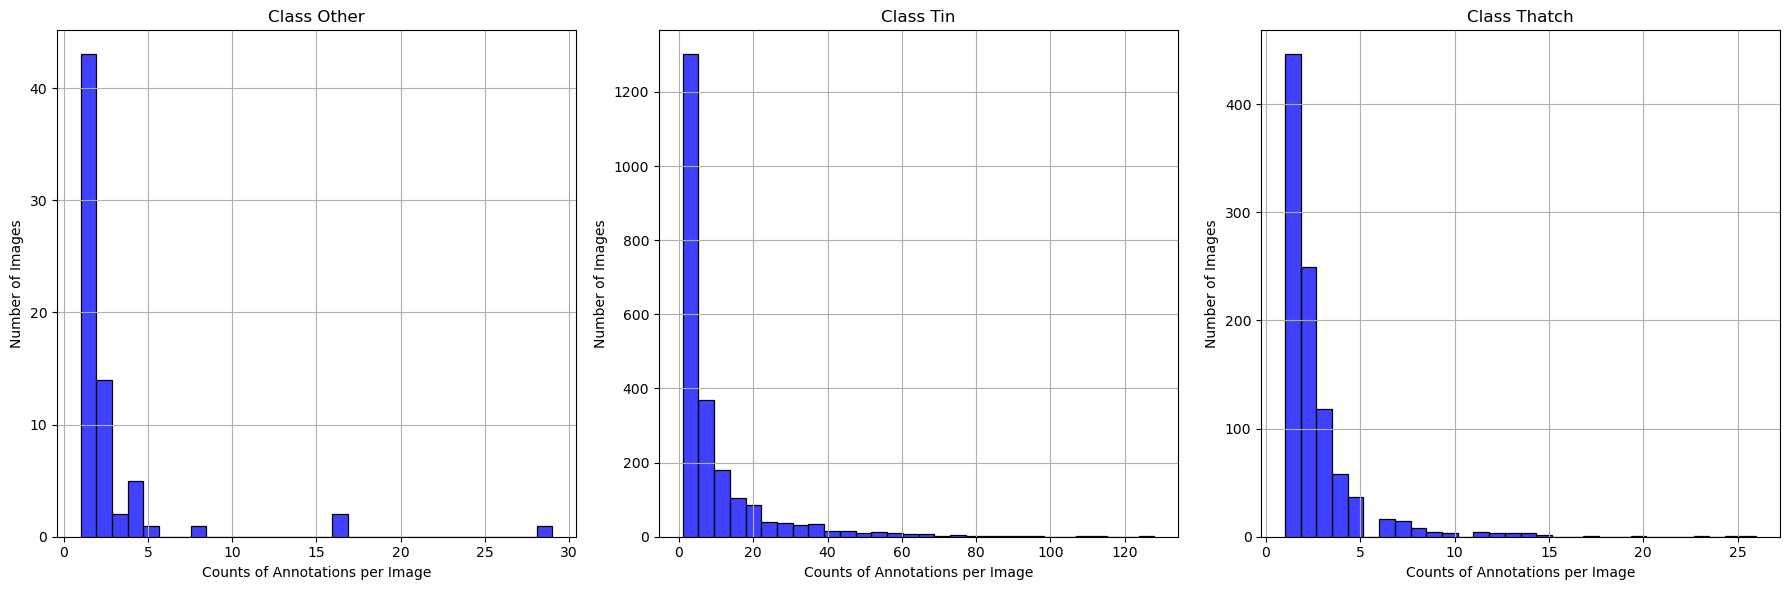

   Category ID  Count Category Name  Percentage of Total
0          1.0    171         Other             0.717011
1          2.0  21330           Tin            89.437712
2          3.0   2348        Thatch             9.845277


In [33]:
# Take a look at object counts per image

# Load the data
TRAIN_CSV = "Data/Train.csv"
train_df = pd.read_csv(TRAIN_CSV)

# Assume 'class_id' is a column in train_df specifying the annotation class
# Aggregate counts of annotations per image per class
annotation_counts = train_df.groupby(['image_id', 'category_id']).size().reset_index(name='counts')

# Plotting
plt.figure(figsize=(18, 6))  # Set the overall figure size

# Define the unique classes - assuming they are 1, 2, 3 as per your 'labels_dict'
classes = [1, 2, 3]
for i, category_id in enumerate(classes, 1):
    plt.subplot(1, 3, i)  # Create a subplot for each class
    class_data = annotation_counts[annotation_counts['category_id'] == category_id]
    sns.histplot(class_data['counts'], bins=30, kde=False, color='blue')
    plt.title(f'Class {labels_dict[category_id]}')
    plt.xlabel('Counts of Annotations per Image')
    plt.ylabel('Number of Images')
    plt.grid(True)  # Optional: Add grid for better readability

plt.tight_layout()
plt.show()

import pandas as pd

# Load the data
TRAIN_CSV = "Data/Train.csv"
train_df = pd.read_csv(TRAIN_CSV)

# Assume 'category_id' is now the column name specifying the annotation category
# Aggregate counts of annotations per category
category_annotation_counts = train_df['category_id'].value_counts().sort_index()

# Convert to DataFrame for better presentation
category_annotation_counts_df = category_annotation_counts.reset_index()
category_annotation_counts_df.columns = ['Category ID', 'Count']

# Add category names based on your existing labels dictionary or similar mapping
labels_dict = {1: "Other", 2: "Tin", 3: "Thatch"}  # Update or modify as per your data
category_annotation_counts_df['Category Name'] = category_annotation_counts_df['Category ID'].map(labels_dict)

# Calculate total annotations to find percentages
total_annotations = category_annotation_counts_df['Count'].sum()
category_annotation_counts_df['Percentage of Total'] = (category_annotation_counts_df['Count'] / total_annotations) * 100

# Print the table with all the required information
print(category_annotation_counts_df)




In [34]:
# Creates COCO format .json from csv / images

#Functions for creating COCO format json
train = pd.read_csv(TRAIN_CSV, header=0)
train.dropna(inplace=True)

train['bbox'] = train['bbox'].apply(ast.literal_eval)

# Initialize the COCO format dictionary
coco_format = {
    "images": [],
    "annotations": [],
    "categories": [
        {"id": 1, "name": "Other"},
        {"id": 2, "name": "Tin"},
        {"id": 3, "name": "Thatch"}
    ]
}
index_dict = {}
i = 0
unique_image_ids = train['image_id'].unique()
for image_id in unique_image_ids:
    index_dict[image_id] = i
    i += 1


# Helper function to get image dimensions
def get_image_dimensions(image_path):
    with Image.open(image_path) as img:
        return img.width, img.height


if __name__ == '__main__':
    # Populate images section
    unique_image_ids = train['image_id'].unique()
    for image_id in unique_image_ids:
        file_name = f"{image_id}.tif"  # Adjust the extension if needed
        image_path = os.path.join(IMAGE_FOLDER, file_name)
        width, height = get_image_dimensions(image_path)
        coco_format["images"].append({
            "id": index_dict[image_id],
            "file_name": file_name,
            "width": width,
            "height": height
        })

    # Annotations
    for index, row in train.iterrows():
        annotation = {
            "id": index,
            "image_id": index_dict[row["image_id"]],
            "category_id": int(row["category_id"]),
            "bbox": row["bbox"],
            "area": row["bbox"][2] * row["bbox"][3],  # width * height
            "iscrowd": 0,
            "segmentation": []  # Empty if not using segmentation
        }
        coco_format["annotations"].append(annotation)

    # Save to JSON
    with open(r'Data\dataset_coco_format.json', 'w') as f:
        json.dump(coco_format, f, indent=4)

In [36]:
# Weights and Biases - this will help us track and view our training
PROJECT_NAME = 'detr_hous_count'
os.environ['WANDB_NOTEBOOK_NAME'] = 'Getting_started_detr_hf.ipynb'

wandb.login()
wandb.init(project=PROJECT_NAME)

wandb_logger = WandbLogger(name="MyModelRun", project=PROJECT_NAME)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
train_cardinality_error,▇▄▂▄▁▄▄▃▃▂▆█▁▅▃▄▃▅▁▂▄▂▂▄▄▆▅▄▃▃▄▃▂▂▃▄▅
train_loss_bbox,▃▁▁▂▂▂▃▂▂▁▂▃▁▃▄▂▂▂▁▂▁▂▂█▄▁▁▁▂▁▅▂▄▂▂▄▂
train_loss_ce,█▄▂▄▁▃▃▃▄▄▄▄▁▄▂▄▃▃▂▄▂▂▃▂▂▄▃▂▂▂▂▃▃▁▂▃▂
train_loss_giou,▄▂▂▃▃▂▂▂▂▂▂▂▁▄▅▂▂▂▁▃▁▁▂▇▄▂▂▁▃▁█▃▄▂▂▅▃
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
training_loss,▆▃▂▄▃▃▃▃▃▂▃▃▁▅▅▃▂▃▂▄▂▂▂█▄▂▂▂▃▁█▃▅▂▃▅▃
validation_cardinality_error,█▅▄▆▅▅▅▅▄▅▆▄▃▃▁
validation_loss,█▄▄▃▆▃▂▃▂▅▅▃▃▁▂
validation_loss_bbox,█▄▃▃▇▃▂▂▂▆▆▃▃▁▁
validation_loss_ce,█▄▃▃▂▁▁▂▁▂▂▁▂▁▂


In [37]:
# Load the COCO dataset JSON
#Train / Test split the annotation data
with open(os.path.join(DATA_FOLDER, COCO_DATASET), 'r') as f:
    coco = json.load(f)

# Extract annotations and images
annotations = coco['annotations']
images = coco['images']

# Split images directly
images_train, images_val = train_test_split(images, test_size=0.2)

# Get the IDs of the split images
images_train_ids = {img['id'] for img in images_train}
images_val_ids = {img['id'] for img in images_val}

# Filter annotations to only include those present in train/val images
annotations_train = [ann for ann in annotations if ann['image_id'] in images_train_ids]
annotations_val = [ann for ann in annotations if ann['image_id'] in images_val_ids]

# Create new JSON objects for train and validation sets
coco_train = {'images': images_train, 'annotations': annotations_train, 'categories': coco['categories']}
coco_val = {'images': images_val, 'annotations': annotations_val, 'categories': coco['categories']}

# Save new JSON files for train and validation datasets
with open(os.path.join(DATA_FOLDER, 'train.json'), 'w') as f:
    json.dump(coco_train, f)

with open(os.path.join(DATA_FOLDER, 'val.json'), 'w') as f:
    json.dump(coco_val, f)

In [38]:
import torchvision

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, ann_file, processor):
        """
        Initialize the CocoDetection class which is a subclass of torchvision.datasets.CocoDetection.
        This subclass is designed to integrate a custom preprocessing step for each data retrieval.

        Parameters:
        - img_folder (str): The directory path where the image files are stored.
        - ann_file (str): The path to the COCO annotation file in JSON format.
        - processor (callable): A function or callable object that processes images and their annotations.
                                It is expected to handle tasks like data augmentation, resizing, and normalization.
        """
        # Initialize the superclass with the provided image folder and annotation file.
        super(CocoDetection, self).__init__(img_folder, ann_file)
        
        # Store the processor callable which will be used to preprocess images and annotations.
        self.processor = processor
        
    """  __getitem__ is implicitly used by the DataLoader objects
    DataLoader Interaction: When you create a DataLoader instance for your dataset, PyTorch's DataLoader internally calls the __getitem__ method 
    to retrieve items. 
    This is done batch-wise; the DataLoader fetches several data items by invoking __getitem__ 
    multiple times to form a batch."""
    
    def __getitem__(self, idx):
        """
        Retrieve an image and its annotations by index, process them using the specified processor,
        and return the processed image and target suitable for model training.

        Parameters:
        - idx (int): The index of the data item to fetch.

        Returns:
        - pixel_values (tensor): The processed image tensor ready for input to a model.
        - target (dict): The processed annotations including labels and other necessary information for training.
        """
        # Read in the PIL image and its target in COCO format using the superclass method.
        # This is the standard retrieval process which fetches the raw image and its annotations.
        img, target = super(CocoDetection, self).__getitem__(idx)

        # Here you can optionally add more data augmentation processes to the image and annotations before further processing.

        # Preprocess the image and its annotations. This includes:
        # - Converting the annotations to the format required by the model (e.g., DETR).
        # - Resizing and normalizing the image and annotations.
        # - Using the 'processor' callable to transform the data into tensors and apply any other necessary preprocessing.
        image_id = self.ids[idx]  # Retrieve the image ID from the dataset's index list.
        target = {'image_id': image_id, 'annotations': target}  # Reformat the target dictionary to include the image ID.
        
        # Apply the processor to the image and annotations to transform them into the required format for the model.
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        
        # Extract the processed image tensor and squeeze out any unnecessary batch dimensions.
        pixel_values = encoding["pixel_values"].squeeze()
        
        # Similarly, get the first item from the labels tensor which contains the processed annotations.
        target = encoding["labels"][0]

        # Return the processed image tensor and target annotations.
        return pixel_values, target


In [39]:
# Import the necessary module for the DETR model's image processor.
import torchvision

#Converts Raw COCO format into DETR
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")


train_dataset = CocoDetection(img_folder=IMAGE_FOLDER, ann_file=r'Data/train.json', processor=processor)
val_dataset = CocoDetection(img_folder=IMAGE_FOLDER, ann_file=r'Data/val.json', processor=processor)


print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Number of training examples: 1972
Number of validation examples: 493


Image n°764


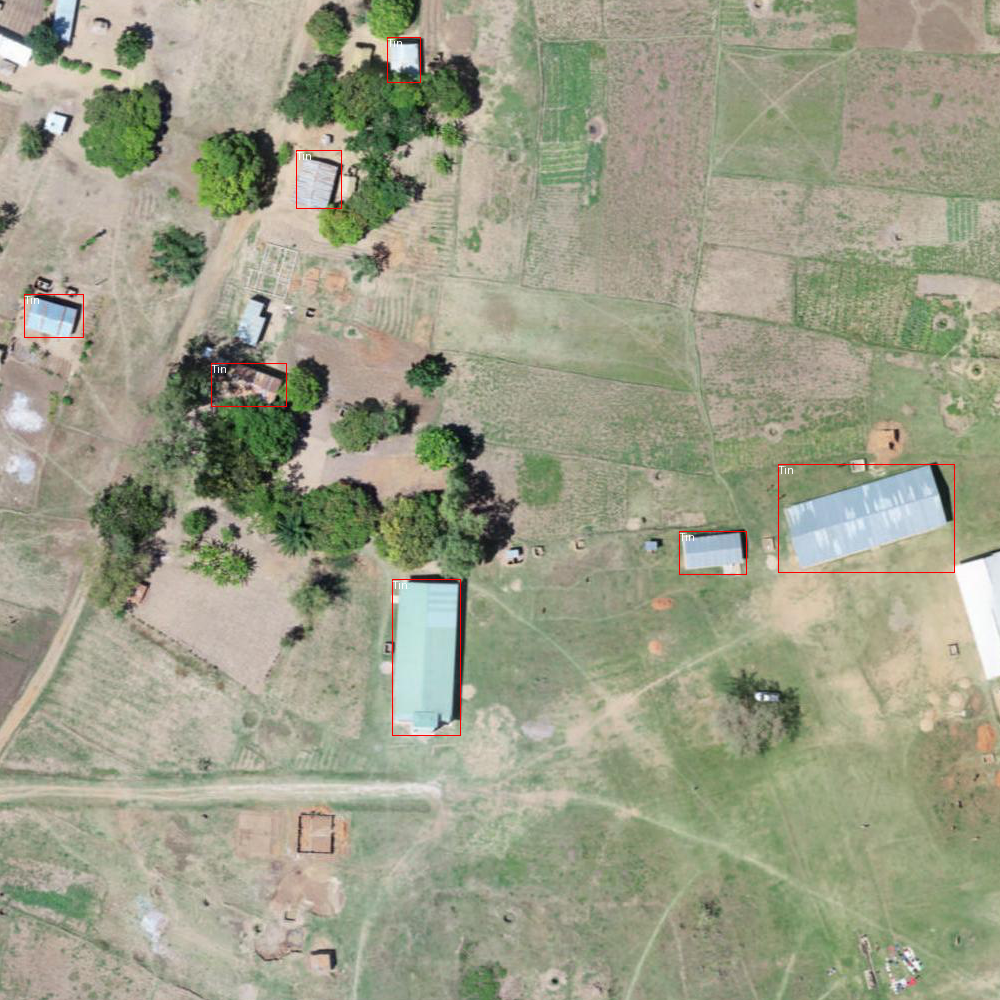

In [94]:
# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(IMAGE_FOLDER, image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image
#1365 thatch (should be tin...)

# 2333 - discard

#74 - small scale

In [41]:
def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    batch = {}
    batch['pixel_values'] = encoding['pixel_values']
    batch['pixel_mask'] = encoding['pixel_mask']
    batch['labels'] = labels
    return batch


train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=8)

In [42]:
class Detr(pl.LightningModule):
    def __init__(self, lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4):
        super().__init__()
        self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50",
                                                            revision="no_timm",
                                                            num_labels=3,
                                                            ignore_mismatched_sizes=True)
        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        return outputs

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("training_loss", loss)
        for k, v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())

        return loss

    def configure_optimizers(self):
        param_dicts = [
            {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                      weight_decay=self.weight_decay)

        return optimizer

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

In [43]:
model = Detr()

trainer = Trainer(max_epochs=15, accelerator='gpu',logger=wandb_logger)
trainer.fit(model)

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([4, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\iansa\anaconda3\envs\torch\lib\site-packages\pytorch_lightning\loggers\wandb.py:391: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUD

Sanity Checking: |                                                                               | 0/? [00:00<…

C:\Users\iansa\anaconda3\envs\torch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
C:\Users\iansa\anaconda3\envs\torch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=15` reached.


In [48]:
device = torch.device("cuda" if torch.cuda.is_available()  else "cpu")
print(device)

cuda


In [52]:
test_df = pd.read_csv(os.path.join('Data',TEST_CSV))

In [53]:

test_list = test_df['image_id'].to_list()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [54]:
def plot_results(img_name):
    image = Image.open(os.path.join(IMAGE_FOLDER, f'{img_name}.tif'))
   
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    print("Outputs:", outputs.keys())    
    postprocessed_outputs  =  processor.post_process_object_detection(outputs,
                                                        target_sizes=[(height, width)],
                                                        threshold=0.9)
    results = postprocessed_outputs[0]

    plt.figure(figsize=(16,10))
    plt.imshow(image)
    ax = plt.gca()
    for score, label, (xmin, ymin, xmax, ymax)  in zip(results['scores'].tolist(), results['labels'].tolist(), results['boxes'].tolist()):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, linewidth=3))
        text = f'{labels_dict[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

Outputs: odict_keys(['logits', 'pred_boxes', 'last_hidden_state', 'encoder_last_hidden_state'])


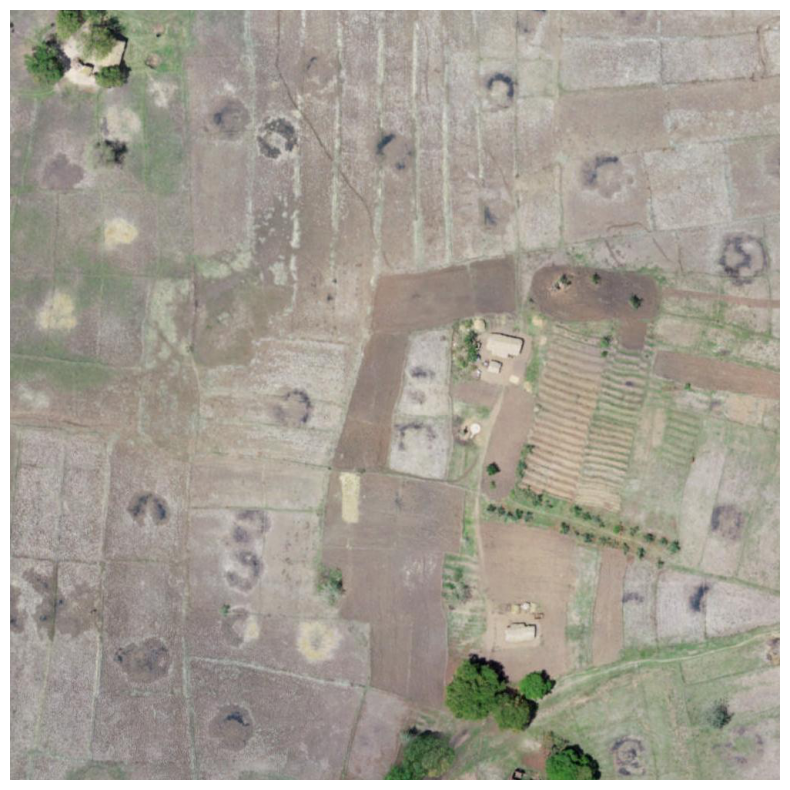

In [83]:
import random
model = model.to(device)
random_img = random.choice(test_list)
plot_results(random_img)